In [1]:
# Boosting - technique that builds an ensemble of weak learners sequentially, with each
        # consecutive learner trying to correct the errors of the one that preceded it. 
    # compare with random_forest, which builds learners in *parallel*, not in *sequence*

# GBM - gradient boosting machine, is often considered a "black box" because its predictions cannot
        # be precisely explainable
        # doesn't extrapolate well; must have seen the data before
        # prone to overfitting. 

# XGBoost - Extreme gradient boosting, an optimized GBM package
    # learning_rate (shrinkage): how much weight is given to each consecutive tree's prediction 
                                    # typical values: 0.01 = 0.3
    # min_child_weight: a tree will not split a node if the child node would have less weight than this value

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
import pickle

In [3]:
df = pd.read_csv('/Users/micahevalt/Downloads/Churn_Modelling.csv')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# basic cleaning and var selection copied from 6_validation NB
df = df.drop(columns = ['RowNumber', 'CustomerId', 'Surname', 'Gender'])
df = pd.get_dummies(df, drop_first = True, dtype = float)

x = df.copy()
x = x.drop(columns = 'Exited')
y = df['Exited']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, 
                                                    stratify = y, random_state = 42)

In [5]:
cv_params = {'n_estimators': [75,100,125],
             'max_depth': [4,5,6,7,8],
             'min_child_weight': [1,2,3,4,5], # <-- last two variables are new as of using XGBoost
             'learning_rate': [0.1,0.2,0.3]
            }

xgb = XGBClassifier(objective = 'binary:logistic', random_state = 0)

scoring = ['accuracy', 'precision', 'f1', 'recall']

xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv=5, refit = 'f1')

In [6]:
%%time
xgb_cv.fit(x_train, y_train)

CPU times: user 11min 9s, sys: 19.9 s, total: 11min 29s
Wall time: 3min 15s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'f1', 'recall'])

In [7]:
xgb_cv.best_score_

0.5811316484816358

In [12]:
pd.DataFrame(xgb_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_accuracy,...,std_test_f1,rank_test_f1,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.103094,0.080747,0.015080,0.001843,0.1,4,1,75,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",0.864667,...,0.017488,52,0.490196,0.418301,0.450980,0.501639,0.426230,0.457469,0.033389,219
1,0.090386,0.021257,0.015726,0.001066,0.1,4,1,100,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",0.867333,...,0.022311,10,0.503268,0.418301,0.457516,0.511475,0.426230,0.463358,0.038343,206
2,0.118390,0.032629,0.016740,0.000501,0.1,4,1,125,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",0.863333,...,0.025437,55,0.503268,0.405229,0.464052,0.518033,0.422951,0.462707,0.043800,211
3,0.076248,0.019013,0.015765,0.000692,0.1,4,2,75,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",0.864667,...,0.019701,83,0.490196,0.405229,0.457516,0.481967,0.426230,0.452228,0.032369,222
4,0.086099,0.003440,0.015957,0.000125,0.1,4,2,100,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch...",0.864000,...,0.020396,1,0.496732,0.415033,0.470588,0.514754,0.439344,0.467290,0.036448,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.177230,0.009026,0.019654,0.000647,0.3,8,4,100,"{'learning_rate': 0.3, 'max_depth': 8, 'min_ch...",0.834000,...,0.027450,196,0.496732,0.418301,0.473856,0.524590,0.472131,0.477122,0.035024,60
221,0.210126,0.006388,0.020939,0.000990,0.3,8,4,125,"{'learning_rate': 0.3, 'max_depth': 8, 'min_ch...",0.834000,...,0.034473,212,0.496732,0.398693,0.470588,0.531148,0.478689,0.475170,0.043544,91
222,0.134969,0.009344,0.018436,0.000512,0.3,8,5,75,"{'learning_rate': 0.3, 'max_depth': 8, 'min_ch...",0.831333,...,0.020747,134,0.490196,0.450980,0.477124,0.531148,0.495082,0.488906,0.026082,2
223,0.182511,0.017693,0.019446,0.000627,0.3,8,5,100,"{'learning_rate': 0.3, 'max_depth': 8, 'min_ch...",0.828667,...,0.023306,168,0.483660,0.447712,0.473856,0.524590,0.504918,0.486947,0.026312,4


In [13]:
pd.DataFrame(xgb_cv.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_min_child_weight',
       'param_n_estimators', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall'],
      dtype='object')

In [9]:
# this performed about as well as the 5x-cross-validated RF model from before.

In [18]:
def make_results(model_name, model_object):
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    #^ fancy way of saying that for 'mean_test_f1' column, find the maximum (along the whole column)
        # value, then take the whole row.
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    table = pd.DataFrame()
    table = table._append({ # '.append' method was renamed to '._append'
    'Model': model_name,
    'F1': f1,
    'Recall': recall,
    'Precision': precision,
    'Accuracy': accuracy
                         },
    ignore_index = True
                        )
    return table

In [20]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.581132,0.46729,0.77566,0.8632


In [21]:
# XGBoost performed best in terms of F1 score and Recall
    # compared to Random Forest CV, Random Forest Validated, and Tuned Decision Tree
    # Random Forest had best precision and accuracy

In [22]:
xgb_cv_preds = xgb_cv.predict(x_test)
print('F1:', f1_score(y_test, xgb_cv_preds))
print('Recall:', recall_score(y_test, xgb_cv_preds))
print('Precision:', precision_score(y_test, xgb_cv_preds))
print('Accuracy:', accuracy_score(y_test, xgb_cv_preds))

F1: 0.6140776699029126
Recall: 0.49705304518664045
Precision: 0.8031746031746032
Accuracy: 0.8728


In [23]:
# Wow, the model performed better on the test data than the validation data on all metrics!

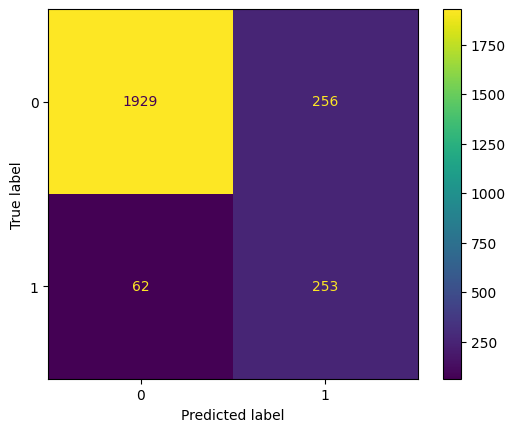

In [26]:
cm = confusion_matrix(xgb_cv_preds, y_test, labels = xgb_cv.classes_)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_cv.classes_).plot()

In [27]:
print(y.value_counts())

Exited
0    7963
1    2037
Name: count, dtype: int64


In [28]:
print(7963/2037)
print(1929/253)

3.9091801669121256
7.624505928853755


Our model's quite good at labelling Negatives (both true and false)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

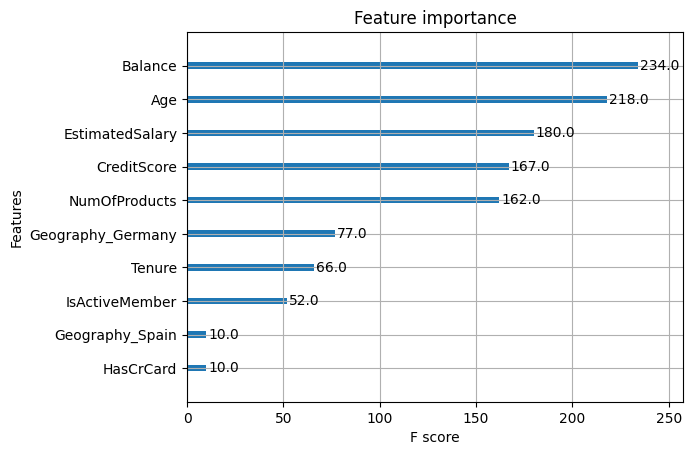

In [30]:
# XGBoost gives us this nifty little feature here...     ;)
plot_importance(xgb_cv.best_estimator_)